# Binary Classification for Legendary Pokemon Dataset

# 1. Import Data and Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, roc_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler, minmax_scale

path = 'D:\\Programing\\GithubDataset\\Pokemon\\'
file = path + 'pokemon.csv' 

ori_df = pd.read_csv(file)
df = ori_df # leave ori_df untouched
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   HP          800 non-null    int64 
 5   Attack      800 non-null    int64 
 6   Defense     800 non-null    int64 
 7   Sp. Atk     800 non-null    int64 
 8   Sp. Def     800 non-null    int64 
 9   Speed       800 non-null    int64 
 10  Generation  800 non-null    int64 
 11  Legendary   800 non-null    bool  
dtypes: bool(1), int64(8), object(3)
memory usage: 69.7+ KB


In [2]:
# convert boolean into 0/1 integer
df.Legendary = df.Legendary.astype(int)

# Rename column names
rename_col = [{'Type 1':'type1'},{'Type 2':'type2'},{'Sp. Atk':'sp_attack'},
              {'Attack':'attack'},{'Defense':'defense'},{'Generation':'generation'}, {'HP':'hp'},
              {'Sp. Def':'sp_defense'},{'Speed':'speed'},{'Name':'name'},
              {'Legendary':'is_legendary'}]
for i in rename_col: 
    df.rename(columns=i, inplace=True)
    
# Fill nan in type2 column with 'uknown' str
df.type2 = df.type2.fillna('unknown')  # first assign unknown, then drop unknown predictors after onehot encoding to include the real data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    800 non-null    int64 
 1   name          800 non-null    object
 2   type1         800 non-null    object
 3   type2         800 non-null    object
 4   hp            800 non-null    int64 
 5   attack        800 non-null    int64 
 6   defense       800 non-null    int64 
 7   sp_attack     800 non-null    int64 
 8   sp_defense    800 non-null    int64 
 9   speed         800 non-null    int64 
 10  generation    800 non-null    int64 
 11  is_legendary  800 non-null    int32 
dtypes: int32(1), int64(8), object(3)
memory usage: 72.0+ KB


In [3]:
df['type1'].unique()

#df.groupby('is_legendary').size()

array(['Grass', 'Fire', 'Water', 'Bug', 'Normal', 'Poison', 'Electric',
       'Ground', 'Fairy', 'Fighting', 'Psychic', 'Rock', 'Ghost', 'Ice',
       'Dragon', 'Dark', 'Steel', 'Flying'], dtype=object)

In [4]:
df['type2'].unique()

array(['Poison', 'unknown', 'Flying', 'Dragon', 'Ground', 'Fairy',
       'Grass', 'Fighting', 'Psychic', 'Steel', 'Ice', 'Rock', 'Dark',
       'Water', 'Electric', 'Fire', 'Ghost', 'Bug', 'Normal'],
      dtype=object)

In [5]:
df.columns

Index(['Unnamed: 0', 'name', 'type1', 'type2', 'hp', 'attack', 'defense',
       'sp_attack', 'sp_defense', 'speed', 'generation', 'is_legendary'],
      dtype='object')

In [6]:
# drop unecessary column for training
df = df.drop(['Unnamed: 0','name'], axis=1)  #,'Type 2','Unnamed: 0.1','Count'

df.head()

,type1,type2,hp,attack,defense,sp_attack,sp_defense,speed,generation,is_legendary
0,Grass,Poison,45,49,49,65,65,45,1,0
1,Grass,Poison,60,62,63,80,80,60,1,0
2,Grass,Poison,80,82,83,100,100,80,1,0
3,Grass,Poison,80,100,123,122,120,80,1,0
4,Fire,unknown,39,52,43,60,50,65,1,0


In [7]:
numeric_cols = df.drop(['type1','type2',], axis=1).columns

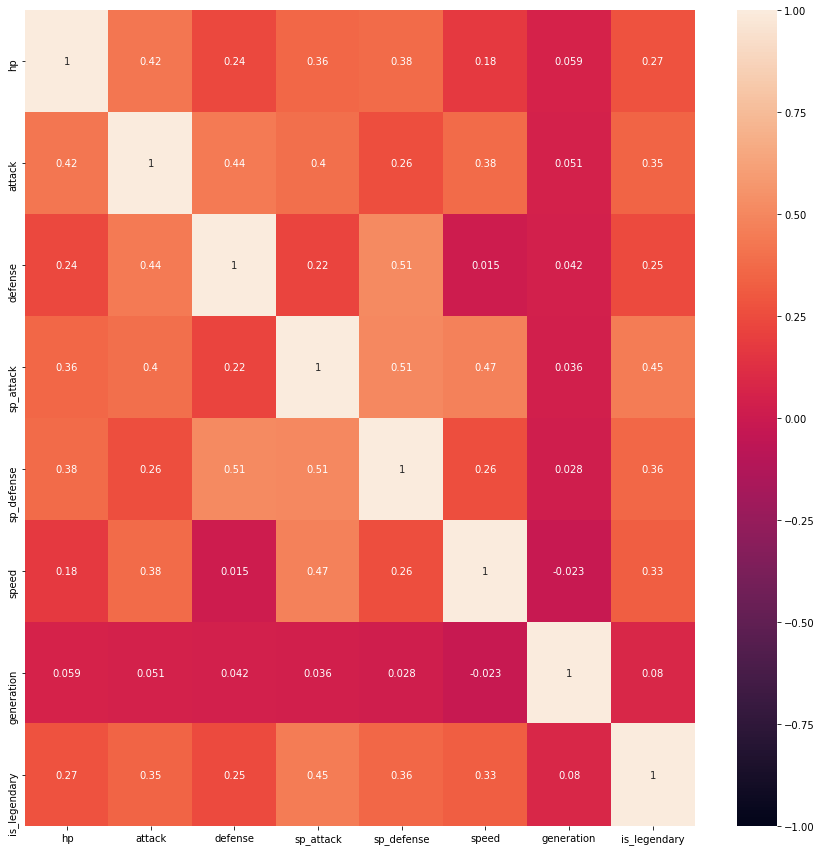

In [8]:
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, annot=True, vmin=-1.0, vmax=1.0)
plt.show()

Index(['hp', 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed',
       'generation', 'is_legendary'],
      dtype='object')


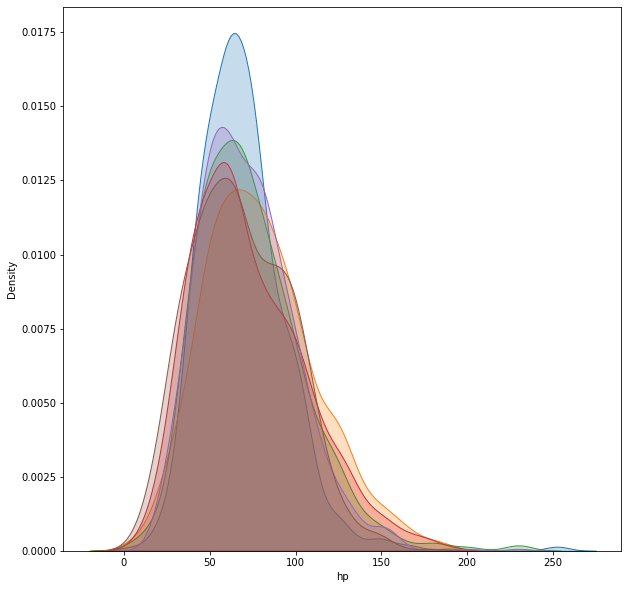

In [9]:
print(numeric_cols)
stronger_predictors = ['hp', 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed']
plt.figure(figsize=(10,10))
for i in stronger_predictors:
    sns.kdeplot(df[i], shade=True)
plt.show()

In [10]:
print(df.groupby(['is_legendary','type2']).size())  # 386 unknown category in Type2 column are not real predictor!

is_legendary  type2   
0             Bug           3
              Dark         19
              Dragon       14
              Electric      5
              Fairy        21
              Fighting     22
              Fire          9
              Flying       84
              Ghost        13
              Grass        25
              Ground       34
              Ice          11
              Normal        4
              Poison       34
              Psychic      28
              Rock         14
              Steel        21
              Water        13
              unknown     361
1             Dark          1
              Dragon        4
              Electric      1
              Fairy         2
              Fighting      4
              Fire          3
              Flying       13
              Ghost         1
              Ground        1
              Ice           3
              Psychic       5
              Steel         1
              Water         1
              unk

# 2. Preprocessing
## 2.1. One-hot Encoding

In [11]:
def onehot_encode(df, col, prefix):
    df = df.copy()
    dummies = pd.get_dummies(df[col],prefix=prefix)
    df = pd.concat([df,dummies], axis=1)
    df = df.drop(col, axis=1)
    return df

In [12]:
df = onehot_encode(df,'type1', 't1')
df = onehot_encode(df,'type2', 't2')
df = df.drop('t2_unknown', axis=1)
df.head()

,hp,attack,defense,sp_attack,sp_defense,speed,generation,is_legendary,t1_Bug,t1_Dark,...,t2_Ghost,t2_Grass,t2_Ground,t2_Ice,t2_Normal,t2_Poison,t2_Psychic,t2_Rock,t2_Steel,t2_Water
0,45,49,49,65,65,45,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,60,62,63,80,80,60,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,80,82,83,100,100,80,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,80,100,123,122,120,80,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,39,52,43,60,50,65,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
numeric_col2 = list(df.columns)
for i in range(len(numeric_col2)):
    if numeric_col2[i] == 'is_legendary':
        print(i)

7


In [14]:
def move_to_end(lst, elem):
  lst = [x for x in lst if x != elem] + [elem]
  return lst

numeric_col2 = move_to_end(numeric_col2, numeric_col2[7])

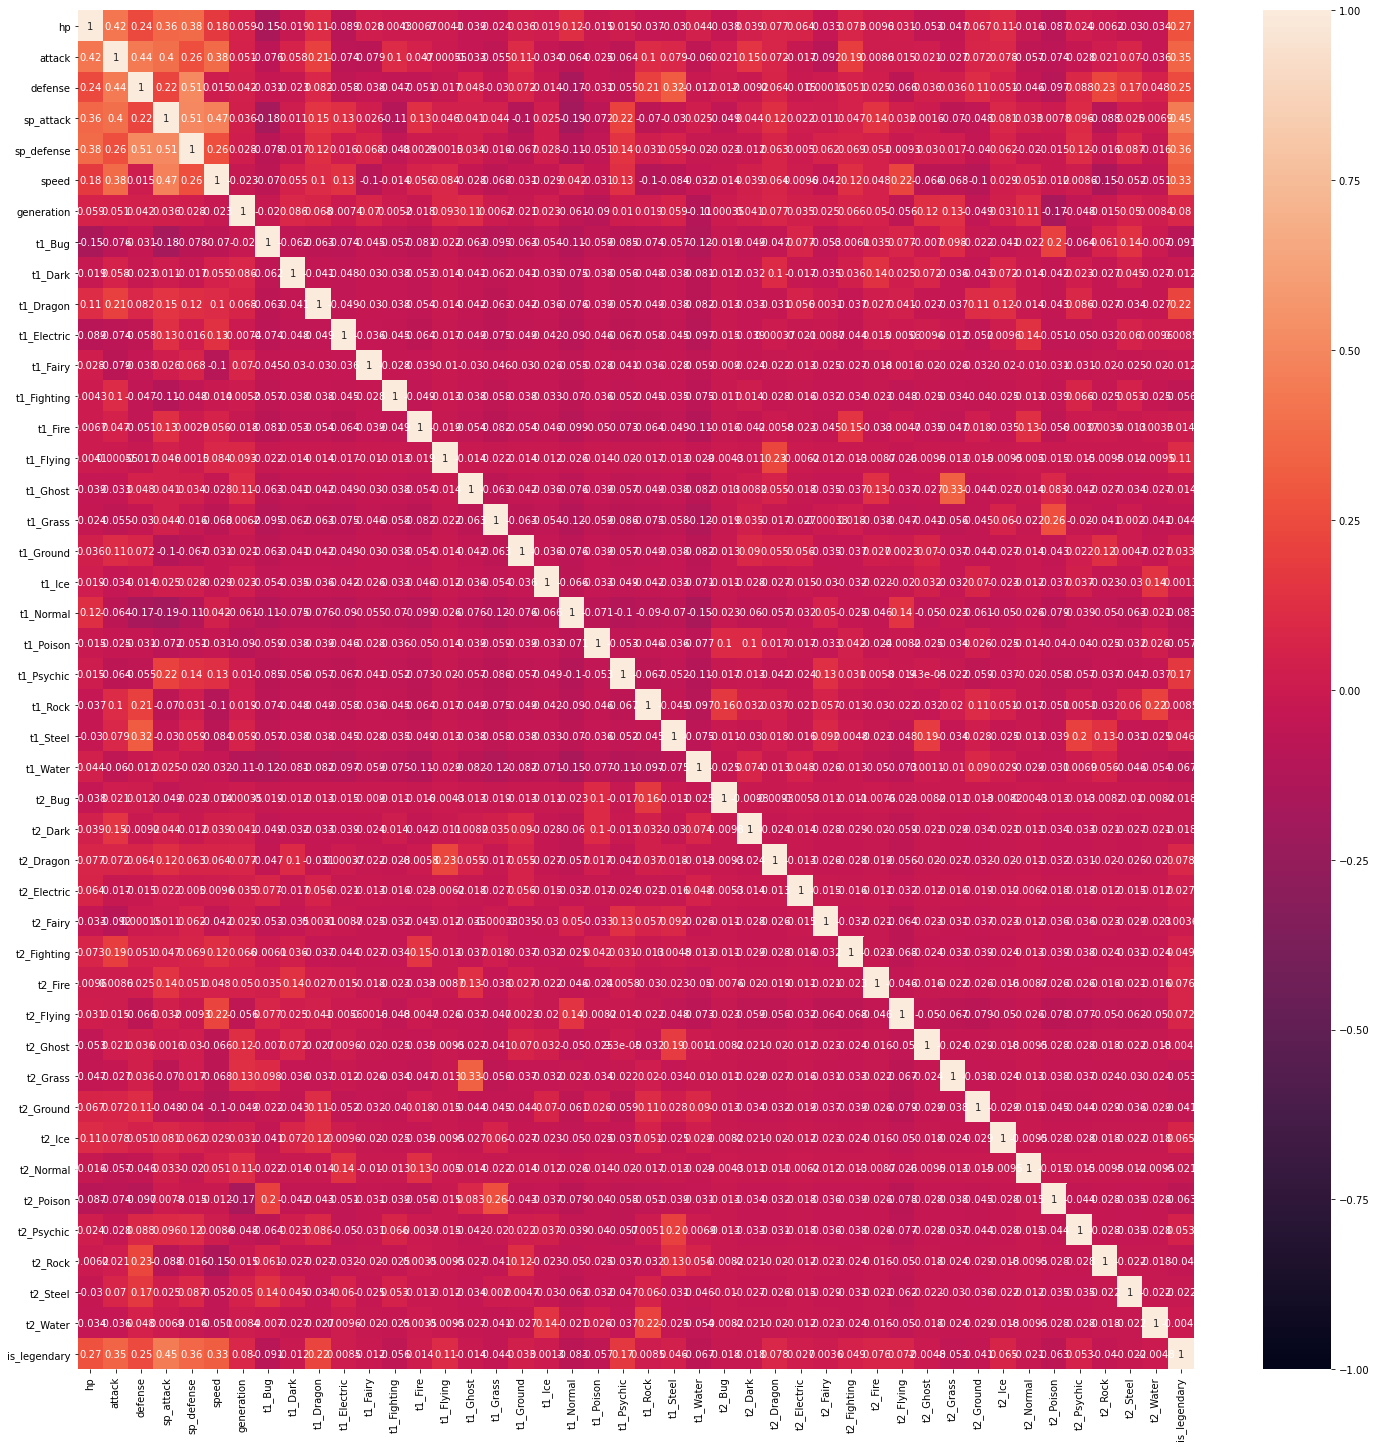

In [15]:
corr_matrix2 = df[numeric_col2].corr()

plt.figure(figsize=(25,25))
sns.heatmap(corr_matrix2, annot=True, vmin=-1.0, vmax=1.0)
plt.show()

## 2.2. Split df into Features, Target, then into Train and Test datasets

In [16]:
y = df.is_legendary
X = df.drop('is_legendary', axis=1)

In [17]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

In [19]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(560, 43)
(560,)
(240, 43)
(240,)


# 3. Building Model and Making Predictions

## 3.1. Random Forest Classifier from Ensemble Model
### 3.1.1. Instantiate Model and Fit Training Dataset

In [20]:
from sklearn.ensemble import RandomForestClassifier

# instantiate and fit training dataset
em1 = RandomForestClassifier(n_estimators=100)
em1.fit(X_train, y_train)

RandomForestClassifier()

In [21]:
# cross validate model with test dataset
y_pred1 = em1.predict(X_test)
y_proba1 = em1.predict(X_test)
em1.score(X_test, y_test)
 # equiv to np.mean(y_pred1 == y_test) and simple acurary_score metrics

0.9583333333333334

In [22]:
roc_auc_score(y_test, y_pred1)  # ROC curve is plot of TPR vs. FPR

0.728888888888889

In [23]:
average_precision_score(y_test, y_pred1)

0.3962962962962963

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

def plot_confusion_matrix (y_true, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    cmdobj = ConfusionMatrixDisplay(cm,display_labels=['Others','Legendary'])
    _, ax = plt.subplots(1, 1, figsize=(5,5))
    ax.grid(False)
    cmdobj.plot(ax=ax, cmap='summer')     # some options: 'Oranges','Accent','Blues','magma', 

def plot_roc_curve(y_real, y_proba):
    fpr, tpr, _ = roc_curve(y_real, y_proba)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.plot([0, 1], [0, 1], color = 'g')
    
def plot_precisionrecall_curve(y_real, y_proba):
    prec, recl, treshold = precision_recall_curve(y_real, y_proba)
    prd = PrecisionRecallDisplay(precision=prec, recall=recl).plot()
    prd.figure_.set_size_inches(5,5)
    plt.ylim((0,1))

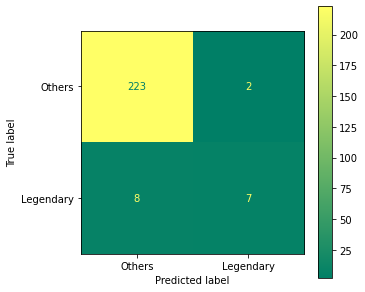

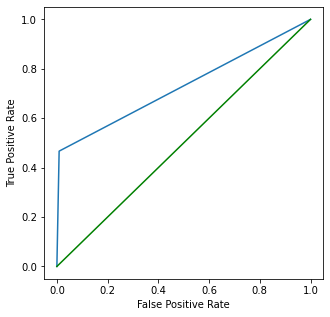

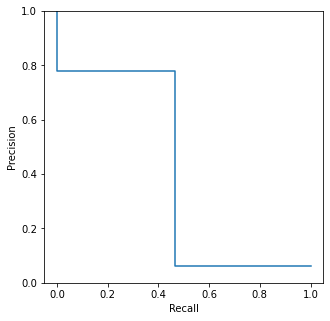

In [25]:
plot_confusion_matrix (y_test, y_pred1)
plot_roc_curve (y_test, y_proba1)
plot_precisionrecall_curve (y_test, y_proba1)

In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred1))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       225
           1       0.78      0.47      0.58        15

    accuracy                           0.96       240
   macro avg       0.87      0.73      0.78       240
weighted avg       0.95      0.96      0.95       240



RandomForrest clf is good at predicting negative event (99% - 222/225), but perform marginally at classifying rare (12/225) positive events (~60% accuracy - 9/15). 

### 3.1.2. Making Predictions and Calculate Prediction Metrics Using RF Classifier

In [27]:
y_pred_RF = em1.predict(X_test)

In [28]:
np.mean(y_pred_RF == y_test)

0.9583333333333334

In [29]:
print('y_pred = ', y_pred_RF)
print('y_test = ', np.array(y_test))

y_pred =  [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
y_test =  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [30]:
roc_auc_score(y_test, y_pred_RF)
# this figure equals to the CV score because the same y_test is used for both validation and for prediction

0.728888888888889

## 3.2. Logistic Regression Linear Model
### 3.2.1. Instantiate Model and Fit Training Dataset

In [31]:
from sklearn.linear_model import LogisticRegression

lm = LogisticRegression()
lm.fit(X_train, y_train)

LogisticRegression()

In [32]:
lm.score(X_test, y_test)

0.9625

### 3.2.2. Make Predictions and Calculate Metrics with Logistic Regression model

In [33]:
y_predLR = lm.predict(X_test)
y_probaLR = lm.predict(X_test)
np.mean(y_predLR == y_test)

0.9625

In [34]:
print('y_pred = ', y_predLR)
print('y_test = ', np.array(y_test))

y_pred =  [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
y_test =  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [35]:
roc_auc_score(y_test, y_predLR)

0.8866666666666668

In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_predLR))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       225
           1       0.67      0.80      0.73        15

    accuracy                           0.96       240
   macro avg       0.83      0.89      0.85       240
weighted avg       0.97      0.96      0.96       240



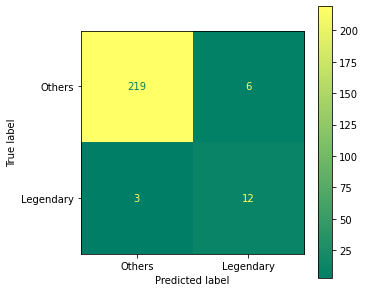

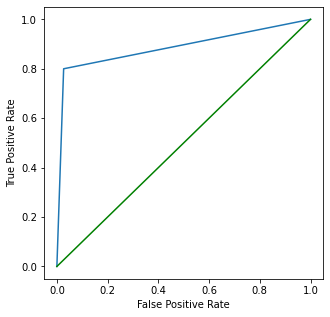

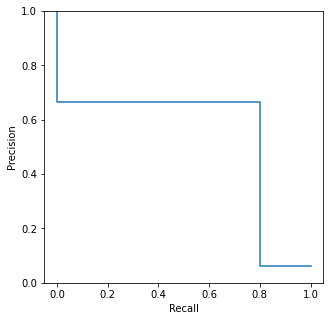

In [37]:
plot_confusion_matrix (y_test, y_predLR)
plot_roc_curve (y_test, y_probaLR)
plot_precisionrecall_curve (y_test, y_probaLR)

# 4. Improving Logistic Regression Model with some Feature Engineering 

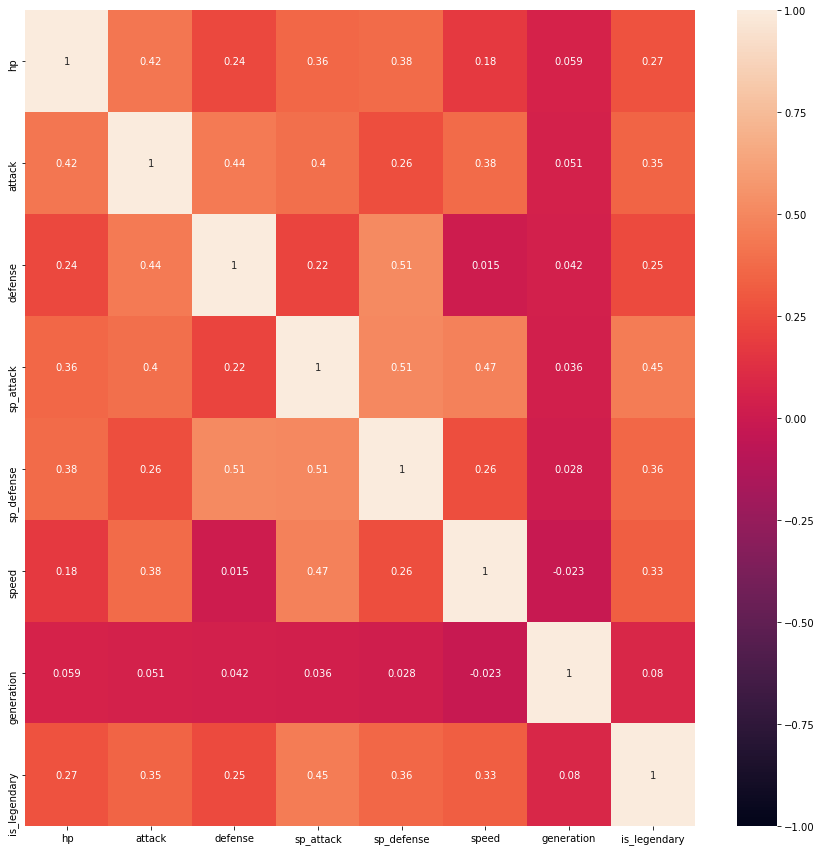

In [38]:
# recall original correlation matrix to see the strength of each predictors
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, annot=True, vmin=-1.0, vmax=1.0)
plt.show()

In [39]:
# Generation feature is not predictive of Legendary pokemon, so drop it.
X2= df

# From corr matrix, rank of the predictor from strongest to weakest: 
  # sp_attack > sp_def > attack > speed > hp > defense

In [40]:
X2.tail(10)

,hp,attack,defense,sp_attack,sp_defense,speed,generation,is_legendary,t1_Bug,t1_Dark,...,t2_Ghost,t2_Grass,t2_Ground,t2_Ice,t2_Normal,t2_Poison,t2_Psychic,t2_Rock,t2_Steel,t2_Water
790,40,30,35,45,40,55,6,0,0,0,...,0,0,0,0,0,0,0,0,0,0
791,85,70,80,97,80,123,6,0,0,0,...,0,0,0,0,0,0,0,0,0,0
792,126,131,95,131,98,99,6,1,0,0,...,0,0,0,0,0,0,0,0,0,0
793,126,131,95,131,98,99,6,1,0,1,...,0,0,0,0,0,0,0,0,0,0
794,108,100,121,81,95,95,6,1,0,0,...,0,0,1,0,0,0,0,0,0,0
795,50,100,150,100,150,50,6,1,0,0,...,0,0,0,0,0,0,0,0,0,0
796,50,160,110,160,110,110,6,1,0,0,...,0,0,0,0,0,0,0,0,0,0
797,80,110,60,150,130,70,6,1,0,0,...,1,0,0,0,0,0,0,0,0,0
798,80,160,60,170,130,80,6,1,0,0,...,0,0,0,0,0,0,0,0,0,0
799,80,110,120,130,90,70,6,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [41]:
# Look for some special feature that might be contributive to legendary to amplify
print(X2.groupby(['is_legendary','sp_attack']).size()) 
    # sp_attack >150 seems to have higher counts of Legendary poke  
    
print(X2.groupby(['is_legendary','sp_defense']).size()) 
print(X2.groupby(['is_legendary','generation']).size()) 
    # generation 1,2 have <5% legendary poke, while gen 3,4,5,6 have ~10% legendary poke 


is_legendary  sp_attack
0             10           3
              15           4
              20           8
              23           1
              24           2
                          ..
1             154          2
              160          2
              170          2
              180          3
              194          1
Length: 125, dtype: int64
is_legendary  sp_defense
0             20             5
              23             1
              25            11
              30            20
              31             1
                            ..
1             140            1
              150            3
              154            2
              160            2
              200            1
Length: 112, dtype: int64
is_legendary  generation
0             1             160
              2             101
              3             142
              4             108
              5             150
              6              74
1             1       

In [42]:
a = ['t1_Dragon','t2_Flying']
x_=['hp','attack','defense','sp_attack','sp_defense','speed','generation']
[x_.append(elem) for elem in a]
y_=['hp','attack','defense','sp_attack','sp_defense','speed','generation']
[y_.append(elem) for elem in a]

print(x_,'\n',y_)

['hp', 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed', 'generation', 't1_Dragon', 't2_Flying'] 
 ['hp', 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed', 'generation', 't1_Dragon', 't2_Flying']


In [ ]:
#sns.PairGrid(X2, hue='is_legendary')

poke = sns.PairGrid(X2, hue='is_legendary',x_vars=x_, y_vars=y_)
poke.map_diag(sns.kdeplot, shade=True)
poke.map_upper(plt.scatter)
poke.map_lower(sns.histplot)

#'hp','attack','defense','sp_attack','sp_defense','speed','generation','is_legendary'

In [ ]:
# Engineer feature columns to make new aggregates
df_eng = pd.DataFrame()
df_eng['is_legendary'] = X2.is_legendary

# weight average arbitrary
df_eng['n1'] = ((6*X2.sp_attack + 5*X2.sp_defense + 4*X2.attack+ 3*X2.speed + 2*X2.hp + X2.defense )/(21))

# weight average based on correlation factor
df_eng['n2'] = ((0.45*X2.sp_attack + 0.36*X2.sp_defense + 0.35*X2.attack+ 0.33*X2.speed + 0.27*X2.hp + 0.25*X2.defense )/(2.01))


df_eng['n3'] = X2.generation*df_eng.n2
df_eng['n4'] = df_eng['n3'].apply(np.log10)
df_eng['n5'] = (X2.sp_attack * X2.sp_defense * X2.attack * X2.speed * X2.hp * X2.defense).apply(np.log10)
df_eng['n6'] = X2.generation * (X2.sp_attack * X2.sp_defense * X2.attack * X2.speed * X2.hp * X2.defense).apply(np.log10)
df_eng['n7'] = (X2.generation * X2.sp_attack * X2.sp_defense * X2.attack * X2.speed * X2.hp * X2.defense).apply(np.log10)

df_eng.tail(20)

In [ ]:
# check correlation of engineered features
corr_matrix3 = df_eng.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix3, annot=True, vmin=-1.0, vmax=1.0)
plt.show()

Test how different combination(s) of additional new feature(s) affect prediction metrics

In [ ]:
#X2['n2'] = df_eng.n2
#X2['n4'] = df_eng.n4
X2['n5'] = df_eng.n5
#X2['n6'] = df_eng.n6

# just choose n5 feature since combinations of more than 1 extra feature doesn't improve (some reduce) performance

In [ ]:
y2 = X2.is_legendary
X2 = X2.drop(['is_legendary'], axis=1)
X2.head()

In [ ]:
scaler = StandardScaler()
X2 = scaler.fit_transform(X2)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, train_size=0.7, random_state=42)

lm = LogisticRegression()
lm.fit(X2_train, y2_train)


In [ ]:
y2_predLR = lm.predict(X2_test)
y2_probaLR = lm.predict(X2_test)
np.mean(y2_predLR == y2_test)

In [ ]:
print(classification_report(y2_test,y2_predLR))
plot_confusion_matrix (y2_test, y2_predLR)
plot_roc_curve (y2_test, y2_probaLR)
plot_precisionrecall_curve (y2_test, y2_probaLR)

In [ ]:
# check distribution of legendary pokemon
print(df.groupby(['is_legendary']).size()) 


Model can predict rare positive event (~10% of population) with 80% accuracy (12/15) and no (negative) event with 98% accuracy (220/225).

# 5. References
1. https://www.youtube.com/watch?v=3Fr1npNxkJk
2. https://neptune.ai/blog/evaluation-metrics-binary-classification
3. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4349800/pdf/pone.0118432.pdf
4. https://www.svds.com/learning-imbalanced-classes/
5. https://deepchecks.com/how-to-check-the-accuracy-of-your-machine-learning-model/
6. Just for fun: https://www.youtube.com/watch?v=D621BWU5_r8